## Churn Analysis

### Churn framing

We model churn as a **binary classification at a given snapshot date**.
- Snapshot date for EDA: end of dataset
- Snapshot date for training: 2011-09-01
- A customer is churned if no purchase occurs in the following 60 days

### Load Libraries and Data

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv('../data/online_retail_cleaned.csv')
data.shape

(406829, 9)

### Calculate revenue and differentiate between purchases and returns

In [3]:
# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Calculate revenue
data['Revenue'] = data['Quantity'] * data['UnitPrice']

# Extract returns
data_returns = data[(data['Quantity'] <= 0) | (data['UnitPrice'] <= 0)].copy()
print("Number of returns:", data_returns.shape)

# Remove returns from the dataset
data_purchases = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)].copy()
print("Number of purchases:", data_purchases.shape)

Number of returns: (8945, 9)
Number of purchases: (397884, 9)


## Feature engineering (full dataset, EDA only)

In [4]:
# Last purchase per customer and churn (for EDA only calculation based on last 60 days of data)
snapshot_date = data_purchases['InvoiceDate'].max() + dt.timedelta(days=1)
print("Snapshot date:", snapshot_date)

last_purchase = (
    data_purchases
    .groupby('CustomerID')['InvoiceDate']
    .max()
    .reset_index()
    .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
)
last_purchase['Recency'] = (snapshot_date - last_purchase['LastPurchaseDate']).dt.days
last_purchase['Churn'] = (last_purchase['Recency'] > 60).astype(int)

print("Churn rate:", last_purchase['Churn'].mean())
last_purchase.head()

Snapshot date: 2011-12-10 12:50:00
Churn rate: 0.4476717381281697


,CustomerID,LastPurchaseDate,Recency,Churn
0,12346.0,2011-01-18 10:01:00,326,1
1,12347.0,2011-12-07 15:52:00,2,0
2,12348.0,2011-09-25 13:13:00,75,1
3,12349.0,2011-11-21 09:51:00,19,0
4,12350.0,2011-02-02 16:01:00,310,1


In [5]:
# Frequency (number of orders)
frequency = data_purchases.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'NumOrders']
frequency.head()

,CustomerID,NumOrders
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [6]:
# Costumer age in days
first_purchase = (
    data_purchases
    .groupby('CustomerID')['InvoiceDate']
    .min()
    .reset_index()
    .rename(columns={'InvoiceDate': 'FirstPurchase'})
)
customer_age = (
    last_purchase[['CustomerID', 'LastPurchaseDate']]
    .merge(first_purchase, on='CustomerID', how='left')
)
customer_age['CustomerAgeDays'] = (
    customer_age['LastPurchaseDate'] - customer_age['FirstPurchase']
    ).dt.days
customer_age = customer_age[['CustomerID', 'LastPurchaseDate', 'CustomerAgeDays']]
print(customer_age.head())

   CustomerID    LastPurchaseDate  CustomerAgeDays
0     12346.0 2011-01-18 10:01:00                0
1     12347.0 2011-12-07 15:52:00              365
2     12348.0 2011-09-25 13:13:00              282
3     12349.0 2011-11-21 09:51:00                0
4     12350.0 2011-02-02 16:01:00                0


In [7]:
# Monetary - total revenue and average spent per customer (based on purchases only)
# 1. Calculate total revenue per invoice
invoice_totals = data_purchases.groupby(['CustomerID', 'InvoiceNo'])['Revenue'].sum().reset_index()
# 2. Calculate total and average revenue per customer
monetary = invoice_totals.groupby('CustomerID')['Revenue'].agg(['sum', 'mean']).reset_index()
monetary.columns = ['CustomerID', 'TotalRevenue', 'AvgOrderValue']
monetary.head()

,CustomerID,TotalRevenue,AvgOrderValue
0,12346.0,77183.60,77183.600000
1,12347.0,4310.00,615.714286
2,12348.0,1797.24,449.310000
3,12349.0,1757.55,1757.550000
4,12350.0,334.40,334.400000


In [8]:
# Number of returns per customer
num_returnorders = data_returns.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
num_returnorders.columns = ['CustomerID', 'NumReturnOrders']
num_returnorders.head()

,CustomerID,NumReturnOrders
0,12346.0,1
1,12352.0,3
2,12359.0,2
3,12362.0,3
4,12365.0,1


In [9]:
# Total return value per customer
return_revenue = data_returns.groupby('CustomerID')['Revenue'].sum().reset_index()
return_revenue.columns = ['CustomerID', 'ReturnRevenue']
return_revenue['ReturnRevenue'] = return_revenue['ReturnRevenue'].abs()
return_revenue.head()

,CustomerID,ReturnRevenue
0,12346.0,77183.60
1,12352.0,960.63
2,12359.0,127.05
3,12362.0,71.65
4,12365.0,320.69


In [10]:
# Product diversity (number of unique products purchased)
product_diversity = data_purchases.groupby('CustomerID')['StockCode'].nunique().reset_index()
product_diversity.columns = ['CustomerID', 'NumProducts']  
product_diversity.head()

,CustomerID,NumProducts
0,12346.0,1
1,12347.0,103
2,12348.0,22
3,12349.0,73
4,12350.0,17


In [11]:
# Geography (Country)
country = data.groupby('CustomerID')['Country'].first().reset_index()
country.columns = ['CustomerID', 'Country']
country.head()

,CustomerID,Country
0,12346.0,United Kingdom
1,12347.0,Iceland
2,12348.0,Finland
3,12349.0,Italy
4,12350.0,Norway


In [12]:
# Merge all together
customer_features = last_purchase.merge(frequency, on='CustomerID', how='left')
customer_features = customer_features.merge(customer_age[['CustomerID', 'CustomerAgeDays']], on='CustomerID', how='left')
customer_features = customer_features.merge(monetary, on='CustomerID', how='left')
customer_features = customer_features.merge(num_returnorders, on='CustomerID', how='left')
customer_features = customer_features.merge(return_revenue, on='CustomerID', how='left')
customer_features = customer_features.merge(product_diversity, on='CustomerID', how='left')
customer_features = customer_features.merge(country, on='CustomerID', how='left')

# Fill NaNs for customers with no returns
customer_features['NumReturnOrders'] = customer_features['NumReturnOrders'].fillna(0)
customer_features['ReturnRevenue'] = customer_features['ReturnRevenue'].fillna(0)

In [13]:
customer_features

,CustomerID,LastPurchaseDate,Recency,Churn,NumOrders,CustomerAgeDays,TotalRevenue,AvgOrderValue,NumReturnOrders,ReturnRevenue,NumProducts,Country
0,12346.0,2011-01-18 10:01:00,326,1,1,0,77183.60,77183.600000,1.0,77183.60,1,United Kingdom
1,12347.0,2011-12-07 15:52:00,2,0,7,365,4310.00,615.714286,0.0,0.00,103,Iceland
2,12348.0,2011-09-25 13:13:00,75,1,4,282,1797.24,449.310000,0.0,0.00,22,Finland
3,12349.0,2011-11-21 09:51:00,19,0,1,0,1757.55,1757.550000,0.0,0.00,73,Italy
4,12350.0,2011-02-02 16:01:00,310,1,1,0,334.40,334.400000,0.0,0.00,17,Norway
...,...,...,...,...,...,...,...,...,...,...,...,...
4333,18280.0,2011-03-07 09:52:00,278,1,1,0,180.60,180.600000,0.0,0.00,10,United Kingdom
4334,18281.0,2011-06-12 10:53:00,181,1,1,0,80.82,80.820000,0.0,0.00,7,United Kingdom
4335,18282.0,2011-12-02 11:43:00,8,0,2,118,178.05,89.025000,1.0,1.45,12,United Kingdom
4336,18283.0,2011-12-06 12:02:00,4,0,16,333,2094.88,130.930000,0.0,0.00,263,United Kingdom


Possible additional features: 
* AvgInterpurchaseTime
* ReveuePerMonth
* ReturnRate
* Trend features (e.g. last 3 months vs earlier)

## EDA

In [14]:
print("Number of samples:", len(customer_features.CustomerID))
print("Number of features:", customer_features.shape[1] - 4)  # Exclude CustomerID, Churn, Recency and LastPurchaseDate

Number of samples: 4338
Number of features: 8


In [15]:
# Drop unnecessary columns for modeling
customer_features = customer_features.drop(columns=['CustomerID', 'LastPurchaseDate', 'Recency'])

#### Check Missing values

In [16]:
# Missing values check
print("Missing values in features:\n", customer_features.isnull().sum())

Missing values in features:
 Churn              0
NumOrders          0
CustomerAgeDays    0
TotalRevenue       0
AvgOrderValue      0
NumReturnOrders    0
ReturnRevenue      0
NumProducts        0
Country            0
dtype: int64


#### Transform categorical data

In [17]:
# Check usefullness of Country feature
customer_features.groupby('Country')['Churn'].mean().sort_values(ascending=False)


Country
Bahrain                 1.000000
Brazil                  1.000000
European Community      1.000000
Czech Republic          1.000000
Canada                  1.000000
Unspecified             1.000000
United Arab Emirates    1.000000
Saudi Arabia            1.000000
Lebanon                 1.000000
Israel                  1.000000
Lithuania               1.000000
Greece                  0.750000
Australia               0.666667
Channel Islands         0.666667
Poland                  0.666667
Japan                   0.625000
Switzerland             0.600000
Cyprus                  0.571429
Austria                 0.555556
Malta                   0.500000
United Kingdom          0.447194
Netherlands             0.444444
Portugal                0.421053
Belgium                 0.416667
France                  0.402299
Germany                 0.393617
Denmark                 0.375000
Sweden                  0.375000
Spain                   0.357143
EIRE                    0.333333
No

In [18]:
# Rare-category grouping
country_counts = customer_features['Country'].value_counts() 
print(country_counts)
rare_countries = country_counts[country_counts < 30].index

print(" Percentage of country with highest number of customers:", country_counts.iloc[0] / country_counts.sum() * 100)

# Group rare countries into 'Other' and create dummy variables
customer_features['CountryGrouped'] = customer_features['Country'].replace(rare_countries, 'Other')
customer_features = pd.get_dummies(customer_features, columns=['CountryGrouped'], prefix='Country', drop_first=True)

Country
United Kingdom          3920
Germany                   94
France                    87
Spain                     28
Belgium                   24
Switzerland               20
Portugal                  19
Italy                     14
Finland                   12
Norway                    10
Channel Islands            9
Austria                    9
Australia                  9
Netherlands                9
Japan                      8
Sweden                     8
Denmark                    8
Cyprus                     7
Poland                     6
Canada                     4
Unspecified                4
Greece                     4
USA                        4
EIRE                       3
Israel                     3
Malta                      2
Bahrain                    2
United Arab Emirates       2
Iceland                    1
RSA                        1
Lebanon                    1
Saudi Arabia               1
Singapore                  1
Brazil                     1
Czech 

#### Skewness Check

array([[<Axes: title={'center': 'Churn'}>,
        <Axes: title={'center': 'NumOrders'}>,
        <Axes: title={'center': 'CustomerAgeDays'}>],
       [<Axes: title={'center': 'TotalRevenue'}>,
        <Axes: title={'center': 'AvgOrderValue'}>,
        <Axes: title={'center': 'NumReturnOrders'}>],
       [<Axes: title={'center': 'ReturnRevenue'}>,
        <Axes: title={'center': 'NumProducts'}>, <Axes: >]], dtype=object)

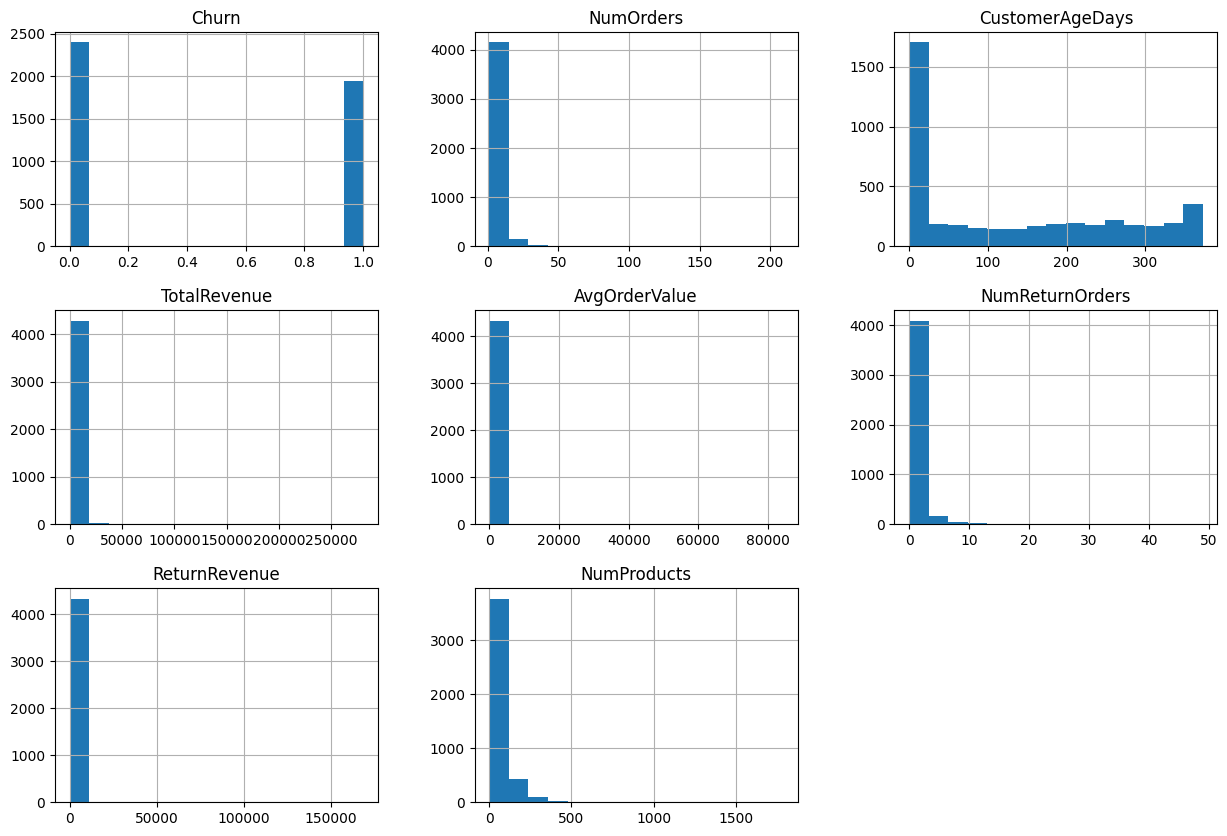

In [19]:
# Histogram of numerical features
numerical_features = customer_features.select_dtypes(include=['int64', 'float64']).columns
customer_features[numerical_features].hist(bins=15, figsize=(15, 10))

array([[<Axes: title={'center': 'Churn'}>,
        <Axes: title={'center': 'NumOrders'}>,
        <Axes: title={'center': 'CustomerAgeDays'}>],
       [<Axes: title={'center': 'TotalRevenue'}>,
        <Axes: title={'center': 'AvgOrderValue'}>,
        <Axes: title={'center': 'NumReturnOrders'}>],
       [<Axes: title={'center': 'ReturnRevenue'}>,
        <Axes: title={'center': 'NumProducts'}>, <Axes: >]], dtype=object)

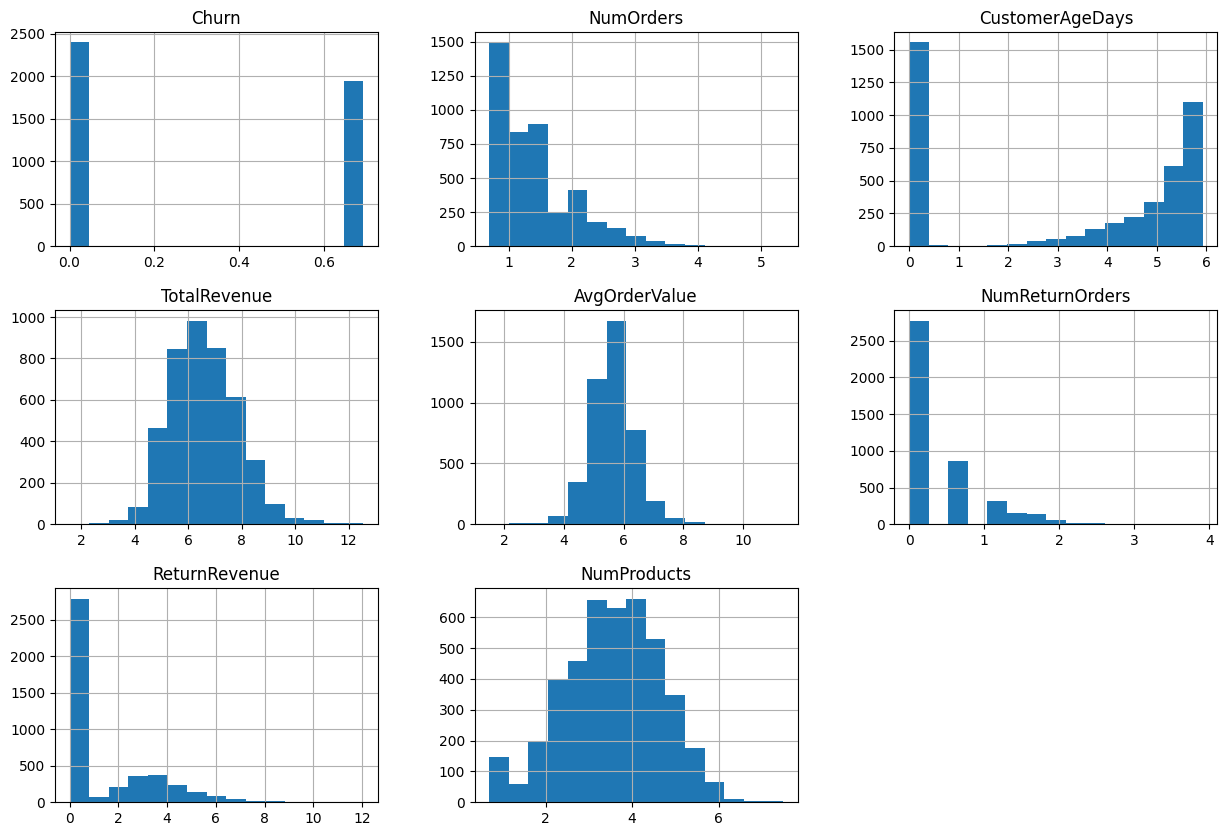

In [20]:
# Histograms of log-transformed numerical features
customer_features_log = customer_features.copy()
for col in numerical_features:
    customer_features_log[col] = np.log1p(customer_features_log[col])  # log1p to handle zero values
customer_features_log.hist(bins=15, figsize=(15, 10))

Keep log tranformed features TotalRevenue, AvgOrderValue, ReturnRevenue and NumProducts.

In [21]:
# Skewness check for numerical features
print("Skewness of features:\n", customer_features[numerical_features].skew())

Skewness of features:
 Churn               0.210542
NumOrders          12.067031
CustomerAgeDays     0.454675
TotalRevenue       19.324953
AvgOrderValue      41.688126
NumReturnOrders     8.924509
ReturnRevenue      47.271631
NumProducts         6.919445
dtype: float64


In [22]:
# Quantiles, 
# if 99th percentile is much higher than 95th percentile and much  higher that 90th percentile, consider capping or transforming
# extreme outliers dominate

customer_features['NumReturnOrders'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])


0.50    0.0
0.75    1.0
0.90    2.0
0.95    4.0
0.99    9.0
Name: NumReturnOrders, dtype: float64

#### Final features

In [23]:
# Define features and target variable
print(customer_features.columns)

# Selected features
selected_features = customer_features.columns.tolist()
# Add log features
log_features = ['TotalRevenue', 'AvgOrderValue', 'ReturnRevenue', 'NumProducts']
selected_features += [f"{col}_log" for col in log_features]
# Remove features not used in modeling
selected_features = [col for col in selected_features 
                     if col not in (['Country', 'Churn'] + log_features)]
print(selected_features)

target_variable = ['Churn']
#selected_features = [['TotalRevenue_log', 'AvgOrderValue_log', 'ReturnRevenue_log', 'NumProducts_log']]

Index(['Churn', 'NumOrders', 'CustomerAgeDays', 'TotalRevenue',
       'AvgOrderValue', 'NumReturnOrders', 'ReturnRevenue', 'NumProducts',
       'Country', 'Country_Germany', 'Country_Other',
       'Country_United Kingdom'],
      dtype='object')
['NumOrders', 'CustomerAgeDays', 'NumReturnOrders', 'Country_Germany', 'Country_Other', 'Country_United Kingdom', 'TotalRevenue_log', 'AvgOrderValue_log', 'ReturnRevenue_log', 'NumProducts_log']


## Feature engineering (training snapshot, leakage-free)

### Functions

In [24]:
def get_historical_data(df, cutoff_date):
    """
    Returns data strictly before cutoff_date
    """
    return df[df['InvoiceDate'] < cutoff_date].copy()

def create_churn_target(df, cutoff_date, churn_days=60):
    """
    Create churn label based on inactivity AFTER last purchase before cutoff
    """

    last_purchase = (
        df[df['InvoiceDate'] < cutoff_date]
        .groupby('CustomerID')['InvoiceDate']
        .max()
        .reset_index()
        .rename(columns={'InvoiceDate': 'LastPurchaseDate'})
    )

    next_purchase = (
        df[df['InvoiceDate'] >= cutoff_date]
        .groupby('CustomerID')['InvoiceDate']
        .min()
        .reset_index()
        .rename(columns={'InvoiceDate': 'NextPurchaseDate'})
    )

    churn_df = last_purchase.merge(
        next_purchase,
        on='CustomerID',
        how='left'
    )

    churn_df['DaysUntilNextPurchase'] = (
        churn_df['NextPurchaseDate'] - churn_df['LastPurchaseDate']
    ).dt.days

    churn_df['Churn'] = np.where(
        churn_df['NextPurchaseDate'].isna() |
        (churn_df['DaysUntilNextPurchase'] > churn_days),
        1,
        0
    )

    return churn_df[['CustomerID', 'LastPurchaseDate', 'Churn']]


def compute_purchase_features(df_hist):
    """
    Creates customer-level behavioral features related to purchases
    """
    # Costumer-level features
    features = df_hist.groupby('CustomerID').agg(
        TotalRevenue=('Revenue', 'sum'),
        AvgOrderValue=('Revenue', 'mean'),
        NumOrders=('InvoiceNo', 'nunique'),
        NumProducts=('StockCode', 'nunique'),
        FirstPurchase=('InvoiceDate', 'min'),
        LastPurchase=('InvoiceDate', 'max')
    ).reset_index()

    features['CustomerAgeDays'] = (
        features['LastPurchase'] - features['FirstPurchase']
    ).dt.days

    features.drop(columns=['FirstPurchase', 'LastPurchase'], inplace=True)

    # Monetory features from invoice totals
    invoice_totals = (
        df_hist
        .groupby(['CustomerID', 'InvoiceNo'])['Revenue']
        .sum()
        .reset_index()
    )
    monetary = (
        invoice_totals
        .groupby('CustomerID')
        .agg(
            InvoicAvgOrderValue=('Revenue', 'mean'),
        )
        .reset_index()
    )

    features = features.merge(monetary, on='CustomerID', how='left')

    return features

def compute_return_features(data_returns):
    """
    Creates customer-level behavioral features related to returns
    """
    return_features = (
        data_returns
        .groupby('CustomerID')
        .agg(
            NumReturnOrders=('InvoiceNo', 'nunique'),
            ReturnRevenue=('Revenue', 'sum')
        )
        .reset_index()
    )
    return_features['ReturnRevenue'] = return_features['ReturnRevenue'].abs()
    return return_features

def compute_country_feature(data, common_countries=None, min_count=50):
    """
    Creates a country feature: top three countries get their own dummy variables and bins rare countries into 'Other'.
    - If common_countries is None → training mode
    - If common_countries is provided → test mode
    """

    data = data.copy()

    # TRAINING
    if common_countries is None:
        # Costumer per country
        country_counts = (
            data
            .groupby('Country')['CustomerID']
            .nunique()
            .sort_values(ascending=False)
        )
        common_countries = country_counts.head(3).index.tolist()

    # Bin rare countries
    data['CountryGrouped'] = data['Country'].apply(
        lambda x: x if x in common_countries else 'Other'
    )

    # Create dummy variables
    country_dummies = pd.get_dummies(data['CountryGrouped'], prefix='Country', drop_first=True)
    
    # Combine CustomerID with dummies
    result = pd.concat([data[['CustomerID']], country_dummies], axis=1)
    

    return result, common_countries


def build_modeling_table(df, cutoff_date, common_countries = None, churn_days=60):
    """
    Full pipeline: features + churn label
    """
    # Create features
    df_hist = get_historical_data(df, cutoff_date)
    df_hist_purchases = df_hist[(df_hist['Quantity'] > 0) & (df_hist['UnitPrice'] > 0)].copy()
    df_hist_returns = df_hist[(df_hist['Quantity'] <= 0) | (df_hist['UnitPrice'] <= 0)].copy()

    purchase_features = compute_purchase_features(df_hist_purchases)
    return_features = compute_return_features(df_hist_returns)
    country_feature, common_countries = compute_country_feature(df_hist_purchases)
    features = purchase_features.merge(
        return_features,
        on='CustomerID',
        how='left'
    ).fillna(0)
    features = features.merge(
        country_feature,
        on='CustomerID',
        how='left'
    )
    # Create log features
    for col in ['TotalRevenue', 'AvgOrderValue', 'ReturnRevenue', 'NumProducts']:
        features[f"{col}_log"] = np.log1p(features[col])

    # Create churn target
    df_purchases = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()
    target = create_churn_target(df_purchases, cutoff_date, churn_days)

    modeling_df = features.merge(
        target,
        on='CustomerID',
        how='inner'
    )

    return modeling_df, common_countries

### Recalculate features and churn with new cutoff dates
Only knowledge from before the cutoff date 

In [25]:
train_cutoff = pd.Timestamp("2011-08-01")
test_cutoff = pd.Timestamp("2011-10-01")

train_df, country = build_modeling_table(data, train_cutoff)
test_df, _ = build_modeling_table(data, test_cutoff, common_countries=country)

print("Training set churn rate:", train_df.Churn.mean())
print("Test set churn rate:", test_df.Churn.mean())

Training set churn rate: 0.5516093452321268
Test set churn rate: 0.49942025178708793


In [26]:
# Prepare training and test data
X_train = train_df[selected_features]
y_train = train_df[target_variable]
X_test = test_df[selected_features]
y_test = test_df[target_variable]

In [27]:
X_train.columns

Index(['NumOrders', 'CustomerAgeDays', 'NumReturnOrders', 'Country_Germany',
       'Country_Other', 'Country_United Kingdom', 'TotalRevenue_log',
       'AvgOrderValue_log', 'ReturnRevenue_log', 'NumProducts_log'],
      dtype='object')

## Logistic regression model (baseline)

### Build and test

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test) # class prediction
y_proba = model.predict_proba(X_test)[:, 1] # probability estimates

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba)) # Area Under the Receiver Operating Characteristic Curve


              precision    recall  f1-score   support

           0       0.76      0.81      0.78    133402
           1       0.79      0.74      0.77    133093

    accuracy                           0.78    266495
   macro avg       0.78      0.78      0.77    266495
weighted avg       0.78      0.78      0.78    266495

ROC AUC Score: 0.8714478635847741


Precision: Of all customers predicted to churn, how many actually churned?

Recall (Sensitivity): Of all customers who actually churned, how many did the model catch?

F1 Score: Harmonic mean of precision and recall.


The model distinguishes churners from non-churners very well.

Balanced performance across classes with no obvious bias toward one class.

The good performance of logistic regression suggests a strong, mostly linear signal.

#### Check impact of classification threshold on precision and recall

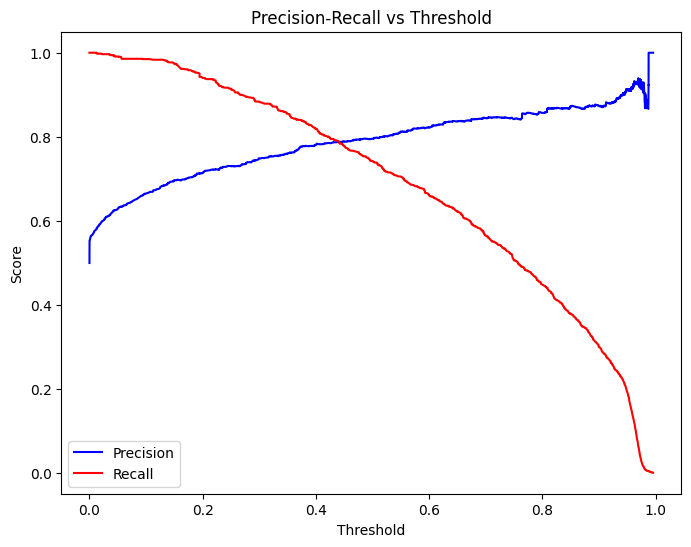

In [29]:
# Plot precission-recall against different thresholds
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

Assuming that a higher recall is more important than precision in this context, we can choose a threshold that balances these metrics according to business needs.

Threshold for at least 0.9 recall: 0.26643720572577584
              precision    recall  f1-score   support

           0       0.87      0.67      0.76    133402
           1       0.73      0.90      0.81    133093

    accuracy                           0.79    266495
   macro avg       0.80      0.79      0.78    266495
weighted avg       0.80      0.79      0.78    266495



Text(0.5, 0, 'Predicted label')

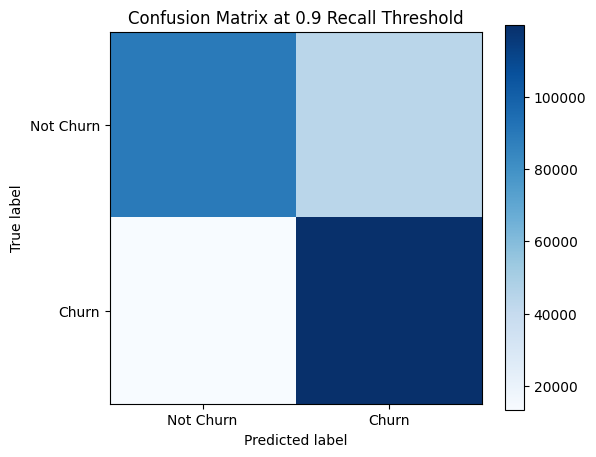

In [30]:
# Chose threshold so that recall is at least 0.90 and compute corresponding threshold
threshold_90_recall = thresholds[np.max(np.where(recall[:-1] >= 0.9))]
print("Threshold for at least 0.9 recall:", threshold_90_recall)
# Apply new threshold to get class predictions
y_pred_90_recall = (y_proba >= threshold_90_recall).astype(int)
print(classification_report(y_test, y_pred_90_recall))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_90_recall)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix at 0.9 Recall Threshold')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Churn', 'Churn'])
plt.yticks(tick_marks, ['Not Churn', 'Churn'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Stability analysis

In [40]:
# Use rolling/expanding window approach for train/test split
from sklearn.metrics import precision_score, recall_score
def rolling_window_modeling(df, start_date, end_date, step_months=1, train_months=3, churn_days=60, threshold=None):
    """
    Perform rolling window modeling
    Parameters:
    - df: original dataframe
    - start_date: start date for the training period
    - end_date: end date for the last testing period
    - step_months: number of months to expand the window at each step
    - train_months: initial number of months in the training period
    - churn_days: number of days to define churn
    - threshold: probability threshold for classification
    Returns:
    - DataFrame with ROC AUC scores for each train/test split
    """
    results = []
    current_train_start = start_date

    while current_train_start + pd.DateOffset(months=train_months) + pd.DateOffset(days=churn_days) < end_date:
        train_cutoff = current_train_start + pd.DateOffset(months=train_months)
        test_cutoff = train_cutoff + pd.DateOffset(months=step_months)

        train_df, country = build_modeling_table(df, train_cutoff, churn_days=churn_days)
        test_df, _ = build_modeling_table(df, test_cutoff, common_countries=country, churn_days=churn_days)

        X_train = train_df[selected_features]
        y_train = train_df[target_variable]
        X_test = test_df[selected_features]
        y_test = test_df[target_variable]

        churnrate = y_test.mean()

        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train.values.ravel())

        y_proba = model.predict_proba(X_test)[:, 1]

        y_pred = (y_proba >= threshold).astype(int) if threshold is not None else model.predict(X_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        results.append({
            'TrainCutoff': train_cutoff,
            'TestCutoff': test_cutoff,
            'ChurnRate': churnrate,
            'Precision': precision,
            'Recall': recall,
            'ROC_AUC': roc_auc
        })

        train_months += step_months

    return pd.DataFrame(results)

# Start date equals first date in the dataset
start_date = data['InvoiceDate'].min()
# End date equals last date in the dataset minus churn_days
end_date = data['InvoiceDate'].max() - pd.DateOffset(days=60)
print("Expanding window modeling from", start_date, "to", end_date)
rolling_results = rolling_window_modeling(
    data, start_date, end_date, step_months=1, train_months=3, churn_days=60, threshold = threshold_90_recall
)
print(rolling_results)

Expanding window modeling from 2010-12-01 08:26:00 to 2011-10-10 12:50:00
          TrainCutoff          TestCutoff                         ChurnRate  \
0 2011-03-01 08:26:00 2011-04-01 08:26:00  Churn    0.522413
dtype: float64   
1 2011-04-01 08:26:00 2011-05-01 08:26:00  Churn    0.518014
dtype: float64   
2 2011-05-01 08:26:00 2011-06-01 08:26:00  Churn    0.521587
dtype: float64   
3 2011-06-01 08:26:00 2011-07-01 08:26:00  Churn    0.546488
dtype: float64   
4 2011-07-01 08:26:00 2011-08-01 08:26:00  Churn    0.551609
dtype: float64   
5 2011-08-01 08:26:00 2011-09-01 08:26:00  Churn    0.535866
dtype: float64   

   Precision    Recall   ROC_AUC  
0   0.790018  0.783969  0.866635  
1   0.735619  0.882258  0.865522  
2   0.761365  0.865560  0.873112  
3   0.776306  0.910371  0.885281  
4   0.772924  0.932133  0.897488  
5   0.762578  0.941577  0.896609  


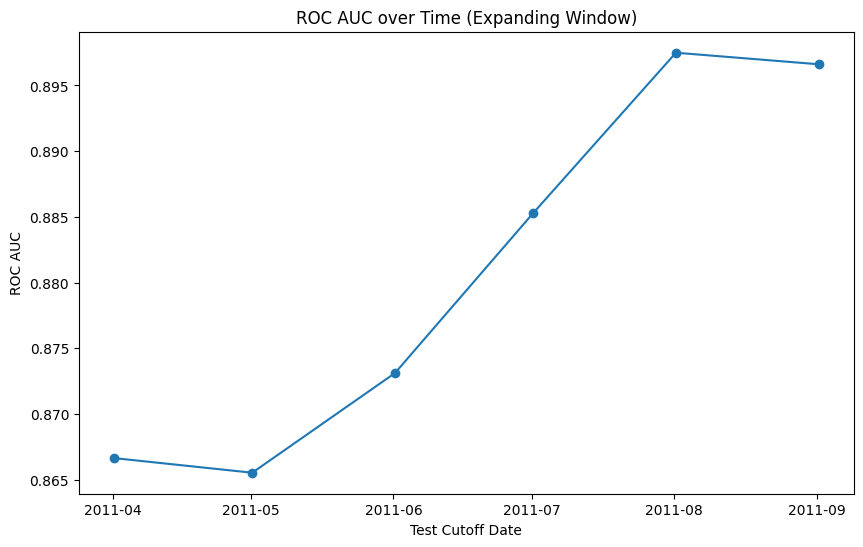

In [32]:
# Plot ROC AUC over time
plt.figure(figsize=(10, 6))
plt.plot(rolling_results['TestCutoff'], rolling_results['ROC_AUC'], marker='o')
plt.title('ROC AUC over Time (Expanding Window)')
plt.xlabel('Test Cutoff Date')
plt.ylabel('ROC AUC')
plt.show()

The model performance is stable over different time windows.

### Calibration Curve and Brier Score

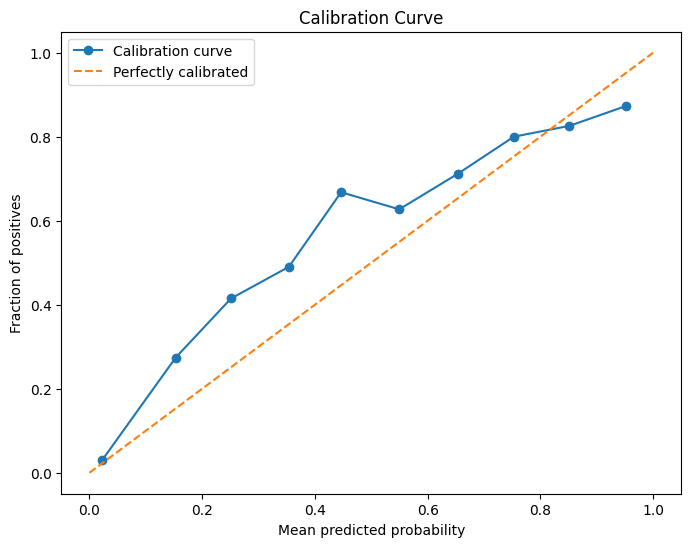

In [33]:
# Calibration curve
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(8, 6))  
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [34]:
# Brier score
from sklearn.metrics import brier_score_loss
brier_score = brier_score_loss(y_test, y_proba)
print("Brier Score:", brier_score)

Brier Score: 0.14973842641761895


The Brier score ranges from 0 to 1, with lower values indicating better calibration. A score of 0.15 suggests that the model's predicted probabilities are reasonably well calibrated.

Summary of logistic regression:
- Strong ROC-AUC (~0.87)
- Stable across time
- Well-calibrated (Brier ~ 0.15)
- Classification threshold alogned with business logic

### Feature interpretation

                  Feature  Coefficient_scaled  OddsRatio
0               NumOrders           -4.105743   0.016478
1         CustomerAgeDays           -0.785948   0.455688
2         NumReturnOrders           -0.709941   0.491673
6        TotalRevenue_log           -0.574017   0.563258
5  Country_United Kingdom           -0.478816   0.619516
4           Country_Other           -0.234240   0.791172
3         Country_Germany           -0.192084   0.825238
7       AvgOrderValue_log           -0.072972   0.929627
9         NumProducts_log            0.098448   1.103457
8       ReturnRevenue_log            0.474364   1.606992


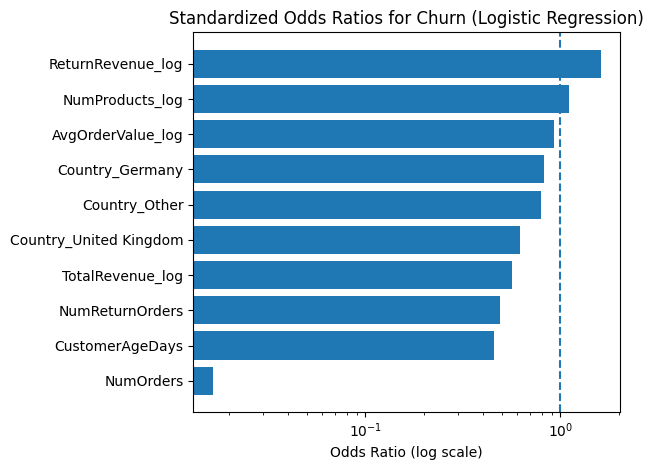

In [44]:
# Feature standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Refit model with scaled features to get a standardized version
model_scaled = LogisticRegression(max_iter=1000, random_state=42)
model_scaled.fit(X_train_scaled, y_train.values.ravel())

# Interpret standardized model coefficients
coef_data = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient_scaled': model_scaled.coef_[0]
}).sort_values(by='Coefficient_scaled', key=abs, ascending=False)

coef_data['OddsRatio'] = np.exp(coef_data['Coefficient_scaled'])
coef_data.sort_values('OddsRatio', inplace=True)

print(coef_data)


plt.figure()
plt.barh(
    coef_data['Feature'],
    coef_data['OddsRatio']
)
plt.axvline(1, linestyle='--')
plt.xscale('log')
plt.xlabel('Odds Ratio (log scale)')
plt.title('Standardized Odds Ratios for Churn (Logistic Regression)')
plt.tight_layout()
plt.show()

Risk features: Return Revenue, Product diversity

Protective features: Average Order value, Country, Total Revenue, Number of returned orders, Customer Age, Number of orders.

Number of Orders is by far the biggest impact feature: Increasing the feature by one standard deviation reduces churn odds by ~98.4%. 

### Error analysis

## Benchmark against Random Forest and XGBoost

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81    133402
           1       0.81      0.81      0.81    133093

    accuracy                           0.81    266495
   macro avg       0.81      0.81      0.81    266495
weighted avg       0.81      0.81      0.81    266495

ROC AUC Score: 0.901646649858382


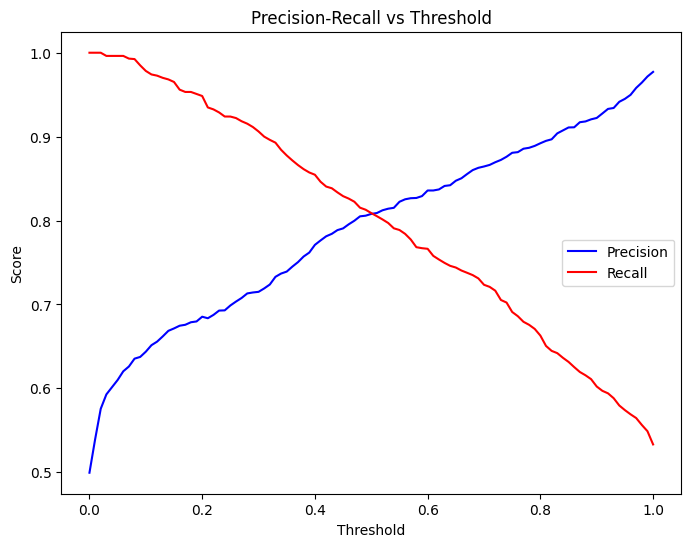

In [36]:
# Plot precission-recall against different thresholds
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()

In [37]:
# Pick threshold so that recall is at least 0.90 and compute corresponding threshold

### XGBoost

In [38]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.81      0.80      0.80    133402
           1       0.80      0.81      0.80    133093

    accuracy                           0.80    266495
   macro avg       0.80      0.80      0.80    266495
weighted avg       0.80      0.80      0.80    266495

ROC AUC Score: 0.8814548636711332


### Feature importance

In [39]:
# Feature importance for Random Forest
importances = model.feature_importances_    
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print(feature_importances)


NumOrders                 0.424603
NumProducts_log           0.086614
CustomerAgeDays           0.083549
Country_United Kingdom    0.073042
TotalRevenue_log          0.070850
NumReturnOrders           0.059870
AvgOrderValue_log         0.055475
ReturnRevenue_log         0.053793
Country_Germany           0.046827
Country_Other             0.045378
dtype: float32


### Top churn drivers with business interpretation